# K Means Clustering

In [2]:
import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial.distance import squareform
from scipy.cluster import hierarchy
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

### Read blood test results as an EMR from an Excel file

In [3]:
# Open the file
xlsx = pd.ExcelFile('EMR-Blood.xlsx')

# Get the first sheet as an object
sheet1 = xlsx.parse(0)

# Set the Key column as the index
sheet1.set_index("Key", inplace=True)

# Show first 10 rows
sheet1.head(10)

,Na,K,ALT,AST,WBC,RBC,Hgb,Hct
Key,,,,,,,,
1,141,4.65,31.92,35.01,10.25,4.06,17.6,36.3
2,140,4.96,36.41,16.70,6.13,3.80,13.2,35.6
3,136,3.66,41.43,13.17,5.86,4.26,16.2,43.7
4,136,4.74,23.92,30.33,10.80,4.83,16.1,49.8
5,140,4.74,43.66,20.44,6.59,4.05,12.6,39.1
6,146,3.98,48.41,33.22,4.53,4.04,17.9,47.3
7,144,5.29,44.29,19.28,10.12,3.96,17.2,47.9
8,138,4.57,50.43,16.39,4.66,4.91,13.7,41.5
9,144,3.96,31.51,34.87,4.57,4.72,15.1,47.6


### Blood Test Abbreviations
- Na == Sodium
- K == Potassium
- ALT == Alanine transaminase
- AST == Aspartate transaminase
- WBC == White blood cells
- RBC == Red blood cells
- Hgb == Hemoglobin
- Hct == Hematocrit

### Using K-Means to create clusters according to variables of uniform distribution

In [4]:
#Retrieve the K, WBC and Hgb column values from the dataset to cluster
variables1 = ["K","WBC","Hgb"]
EMR3d1 = sheet1.loc[:, variables1].values

# Run the K-Means algorithm, assuming the correct number of clusters is 5
y_pred_KMeans1 = KMeans(n_clusters=3,
max_iter=999, n_init=10, random_state=0, ).fit(EMR3d1).labels_


### Make a 3D chart

C:\Users\sfrie\anaconda3\envs\py4dp\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  This is separate from the ipykernel package so we can avoid doing imports until


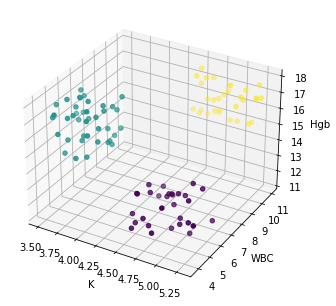

In [5]:
def make_chart (chart_data, y_pred, labels):
    fig = plt.figure()
    ax = Axes3D(fig,)
    ax.set_xlabel(labels[0])
    ax.set_ylabel(labels[1])
    ax.set_zlabel(labels[2])
    ax.scatter(chart_data[:,0], chart_data[:,1], chart_data[:,2], c = y_pred)

make_chart(EMR3d1, y_pred_KMeans1, variables1)

## Part 1-- Kmeans Custom Implementation

Order of operations:

* Implement  Lloyd's Algorithm for solving the K-Means problem, and by examining the WCSS, choose a proper threshold to determine algorithm convergence.

* Check the algorithm on 'EMR-Blood.xlsx' dataset, and compare results to the _sklearn_ version.

In [7]:

# Implement K-Means (X being the data)
class k_means:
    def __init__(self):
        pass
    def fit(self, x, k):
        self.x = np.array(x)
        self.k = k
        #Initiate centroid locations
        # centroids = x[np.random.randint(x.shape[0], size=k), :] #choose random points from out data as centroid initiations.
        centroids = x[np.random.choice(x.shape[0], size = self.k, replace = False), :] #Choose points already in X as initiation.

        prev = 1000000
        WCSS = 100000
        iterations = 1
        while np.abs(prev-WCSS) >= 0.001:
            prev = WCSS
            #Calculate distances of each point to each centroid, and update class to that centroid
            euc = np.array([np.linalg.norm(points - centroids, axis = 1) for points in self.x])
            labels = np.argmin(euc, axis = 1)
            
            # calculate WCSS, then calculate new central positions if it has not converged yet.
            WCSS = 0
            for cent in range(self.k):
                WCSS = np.sum(np.linalg.norm((centroids[cent] - self.x[labels == cent]), axis = 1)**2 )
    
            iterations +=1
            if prev - WCSS <= 0.01: #iterate until WCSS convergence
                self.labels = labels
                self.WCSS = WCSS
                self.centroids = centroids
            # print(f'k: {k}, iterations: {iterations}')
            else:
                centroids = [np.average(self.x[labels==cent], axis = 0) for cent in range(self.k)]
            
            # print(prev)
            # print(WCSS)
    
    def predict(self, X):
        self.X = np.array(X)
        euc = np.array([np.linalg.norm(self.centroids - points, axis = 1) for points in self.x])
        labels = np.argmin(euc, axis = 1)
        return labels



C:\Users\sfrie\anaconda3\envs\py4dp\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  This is separate from the ipykernel package so we can avoid doing imports until


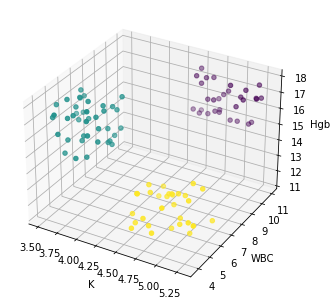

In [9]:
km = k_means()
km.fit(EMR3d1, 3)
make_chart(EMR3d1, km.labels, variables1)

## Part 2: Optimization Using the 'Elbow Method'

Now, we will develop a **generic** mechanism for finding the most reasonable number of clusters by:
1. Iterating K over a reasonable range, which should be derived from the number of points
2. Choose a proper K based on the heuristics learned in class
3. Showing the final clusters in a 3D chart (for your implementation of K-Means algorithm)

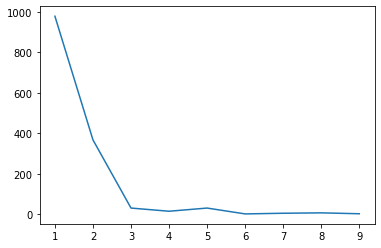

In [22]:
WCSS = []
k_range = int(round(np.sqrt(len(EMR3d1)))) #round on its own wasn't always converting from float
k_vals = np.arange(1,k_range,1)
for k in k_vals:
    km = k_means()
    km.fit(EMR3d1, k)
    WCSS.append(km.WCSS)

plt.plot(k_vals, WCSS)

Using the Elbow method, we detect that the optimal k is at k= 3. Visually, this sits well. When we graph the points on a 3d graph with k = 3, we can see that the groupings look very smooth and logical.